# Data Preprocessing and Analyses 
This notebook serves the exploration of the Paris bike counters data and all data sources or methods used to augment the data. 
It combines code that was used in the bike_counters_starting_kit.ipynb supplemented by further analyses. 

In [1]:
import folium
from jours_feries_france import JoursFeries
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
import re
from vacances_scolaires_france import SchoolHolidayDates

## Initial basic analysis

In [2]:
# load data
data = pd.read_parquet(Path("../data") / "train.parquet")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [3]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

In [4]:
# check the dates in the data set, and that there are no duplicates (summer vs. winter time)
(data.groupby("counter_id").date.value_counts() > 1).sum()

0

In [5]:
print(data.date.min())
print(data.date.max())

2020-09-01 01:00:00
2021-08-09 23:00:00


Check all the counters that exist and display their count

In [6]:
data.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data
Let's visualize the data, starting from the spatial distribution of counters on the map

In [7]:
m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

<AxesSubplot:xlabel='date'>

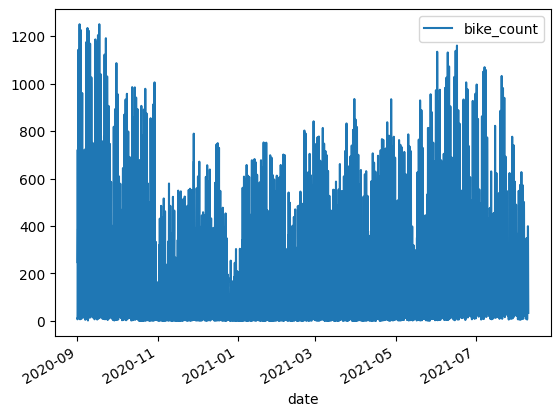

In [8]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture,

<AxesSubplot:xlabel='date'>

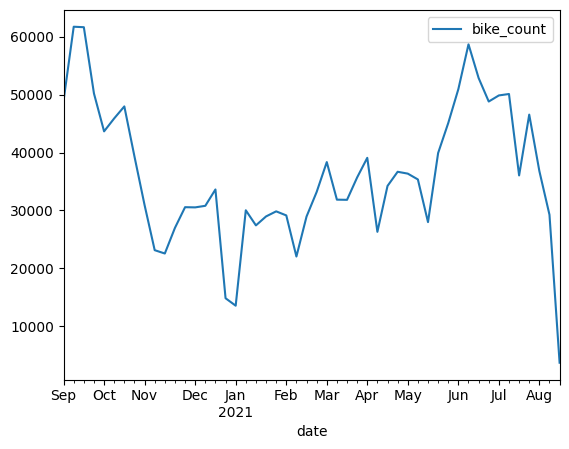

In [9]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<AxesSubplot:xlabel='date'>

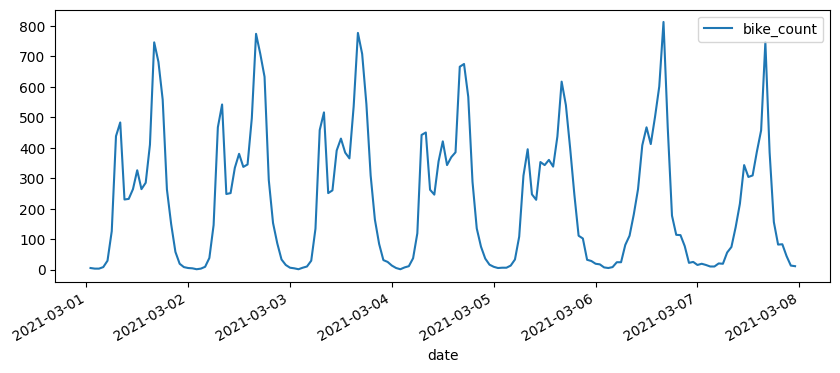

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

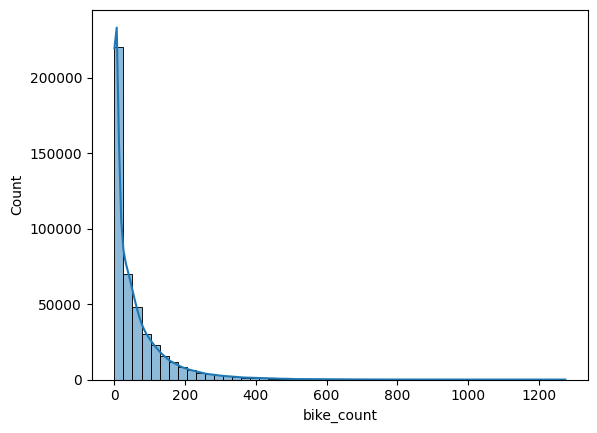

In [11]:
ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

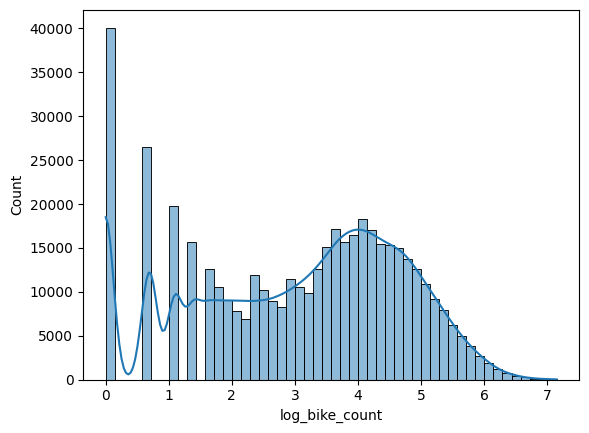

In [12]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

### Transform/augment date variable

In [13]:
def _encode_dates(X: pd.DataFrame) -> pd.DataFrame:
    """
    This function encodes the date variable of a data frame into multiple
    variables and returns the data frame without the date variable.

    Parameters:
        - X (pd.DataFrame): initial data frame with a date variable
    Returns:
        - X (pd.DataFrame): encoded data frame excl. date variable
    """
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [14]:
encoded_dates = _encode_dates(data[["date"]])
encoded_dates.year.unique()

array([2020, 2021])

In [15]:
def _additional_date_variables(X: pd.DataFrame) -> pd.DataFrame:
    """
    This function creates additional variables from a date variable of a data frame,
    i.e., the seasons, the public holidays and school holidays are added.

    Parameters:
        - X (pd.DataFrame): initial data frame with a date variable
    Returns:
        - X (pd.DataFrame): encoded data frame excl. date variable
    """
    X = X.copy()  # modify a copy of X

    # add seasons
    seasons = {
        1: "winter",
        2: "winter",
        3: "spring",
        4: "spring",
        5: "spring",
        6: "summer",
        7: "summer",
        8: "summer",
        9: "autumn",
        10: "autumn",
        11: "autumn",
        12: "winter",
    }
    X.loc[:, "season"] = X["date"].dt.month.map(seasons).astype("category")

    public_holidays = []
    school_holidays = {}
    for year in X["date"].dt.year.unique():
        public_holidays.extend(JoursFeries.for_year(year).values())
        school_holidays.update(
            SchoolHolidayDates().holidays_for_year_and_zone(year, "C")
        )

    # add public holidays
    X.loc[:, "public_holiday"] = X["date"].isin(public_holidays)

    # add school holidays names
    school_holidays_name = {
        k: re.sub("\s+|'", "_", re.sub("[éë]", "e", v["nom_vacances"].lower()))
        for k, v in school_holidays.items()
        if v["vacances_zone_c"]
    }
    X.loc[:, "school_holiday_name"] = (
        X["date"].map(school_holidays_name).astype("category")
    )

    # add school holidays
    school_holidays_bool = [
        k for k, v in school_holidays.items() if v["vacances_zone_c"]
    ]
    X.loc[:, "school_holiday"] = X["date"].isin(school_holidays_bool)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [16]:
additional_dates = _additional_date_variables(data[["date"]])
additional_dates.head()

,season,public_holiday,school_holiday_name,school_holiday
48321,autumn,False,NaN,False
48324,autumn,False,NaN,False
48327,autumn,False,NaN,False
48330,autumn,False,NaN,False
48333,autumn,False,NaN,False


In [17]:
full_data = pd.concat([data, encoded_dates, additional_dates], axis=1)

In [18]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
 11  year                       455163 non-null  int6

## Analyses incl. the weather data

This analysis combines the Prais bike counters data, the augmented date information and the weather data in Paris (see weather_data_analyses.ipynb) for more information.

In [19]:
weather_data_imp = pd.read_csv(
    "../data/weather_data_imp.csv", parse_dates=["date"], dtype={"wdir": "category"}
)
weather_data_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11604 entries, 0 to 11603
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11604 non-null  datetime64[ns]
 1   temp    11604 non-null  float64       
 2   dwpt    11604 non-null  float64       
 3   rhum    11604 non-null  float64       
 4   prcp    11604 non-null  float64       
 5   wdir    11604 non-null  category      
 6   wspd    11604 non-null  float64       
 7   pres    11604 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(6)
memory usage: 651.0 KB


In [20]:
# merge all data sources
df_final = pd.merge(full_data, weather_data_imp, on="date", how="left")

In [21]:
df_final.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,public_holiday,school_holiday_name,school_holiday,temp,dwpt,rhum,prcp,wdir,wspd,pres
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,False,NaN,False,13.0,9.4,79.0,0.0,290.0,3.6,1019.9
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,False,NaN,False,12.9,9.7,81.0,0.0,310.0,5.4,1019.8
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,False,NaN,False,12.4,9.6,83.0,0.0,300.0,5.4,1019.5
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,False,NaN,False,19.8,7.8,46.0,0.0,30.0,14.8,1017.5
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,False,NaN,False,18.9,7.0,46.0,0.0,40.0,11.2,1017.6


In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 0 to 455162
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
 11  year                       455163 non-null  int64   

We look again at the correlation to understand the whole data set better and motivate the following data processing and machine learning in the modeling folder. We see that the correlation between bike_count and the variables are only moderate. Furthermore, there is again the high correlation between temperature and dewpoint. We don't restrict the data set for now and look closer into it in the modeling part. 

In [23]:
excl_cols = df_final.select_dtypes(exclude=["int", "float", "bool"])
corr = df_final.drop(columns=excl_cols).corr()
corr.style.background_gradient(cmap="coolwarm").format(precision=2)

,site_id,bike_count,latitude,longitude,log_bike_count,year,month,day,weekday,hour,public_holiday,school_holiday,temp,dwpt,rhum,prcp,wspd,pres
site_id,1.00,-0.00,-0.13,-0.19,0.02,0.09,-0.07,0.01,0.00,-0.00,0.00,0.00,-0.01,-0.02,-0.02,0.00,0.01,0.00
bike_count,-0.00,1.00,0.13,0.02,0.74,-0.03,0.03,-0.01,-0.08,0.13,-0.02,-0.07,0.26,0.10,-0.26,-0.04,0.03,0.05
latitude,-0.13,0.13,1.00,0.15,0.11,-0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
longitude,-0.19,0.02,0.15,1.00,0.04,-0.01,0.01,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00
log_bike_count,0.02,0.74,0.11,0.04,1.00,-0.02,0.05,-0.01,-0.06,0.27,-0.04,-0.13,0.31,0.14,-0.31,-0.03,0.07,0.03
year,0.09,-0.03,-0.01,-0.01,-0.02,1.00,-0.86,-0.03,0.01,-0.00,0.00,0.02,0.03,-0.15,-0.30,-0.03,0.05,0.13
month,-0.07,0.03,0.01,0.01,0.05,-0.86,1.00,-0.00,-0.01,0.00,0.00,0.01,0.23,0.39,0.23,0.04,-0.09,-0.15
day,0.01,-0.01,-0.00,0.00,-0.01,-0.03,-0.00,1.00,0.02,-0.00,-0.02,0.04,0.03,0.03,0.01,0.01,0.04,0.02
weekday,0.00,-0.08,-0.00,-0.00,-0.06,0.01,-0.01,0.02,1.00,0.00,0.00,0.01,-0.04,-0.01,0.03,-0.00,0.07,0.00
hour,-0.00,0.13,-0.00,-0.00,0.27,-0.00,0.00,-0.00,0.00,1.00,-0.06,-0.19,0.16,0.00,-0.27,-0.01,0.10,-0.01


In [33]:
corr = df_final.drop(columns=excl_cols).corr("spearman")
corr.style.background_gradient(cmap="coolwarm").format(precision=2)

,site_id,bike_count,latitude,longitude,log_bike_count,year,month,day,weekday,hour,public_holiday,school_holiday,temp,dwpt,rhum,prcp,wspd,pres
site_id,1.00,0.09,0.10,-0.36,0.09,0.03,-0.02,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.01,-0.01,-0.00,0.00,0.00
bike_count,0.09,1.00,0.15,-0.00,1.00,-0.02,0.04,-0.01,-0.07,0.25,-0.04,-0.12,0.30,0.13,-0.30,-0.07,0.08,0.03
latitude,0.10,0.15,1.00,0.06,0.15,-0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00
longitude,-0.36,-0.00,0.06,1.00,-0.00,-0.02,0.01,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
log_bike_count,0.09,1.00,0.15,-0.00,1.00,-0.02,0.04,-0.01,-0.07,0.25,-0.04,-0.12,0.30,0.13,-0.30,-0.07,0.08,0.03
year,0.03,-0.02,-0.01,-0.02,-0.02,1.00,-0.83,-0.03,0.01,-0.00,0.00,0.02,0.03,-0.14,-0.31,-0.08,0.05,0.09
month,-0.02,0.04,0.01,0.01,0.04,-0.83,1.00,-0.00,-0.01,0.00,0.00,0.01,0.25,0.40,0.23,0.06,-0.09,-0.14
day,0.00,-0.01,-0.00,0.00,-0.01,-0.03,-0.00,1.00,0.02,-0.00,-0.02,0.04,0.03,0.01,0.03,0.04,0.04,0.00
weekday,0.00,-0.07,-0.00,-0.00,-0.07,0.01,-0.01,0.02,1.00,0.00,0.00,0.01,-0.03,-0.00,0.02,-0.02,0.06,0.02
hour,-0.00,0.25,-0.00,-0.00,0.25,-0.00,0.00,-0.00,0.00,1.00,-0.06,-0.19,0.16,0.00,-0.27,-0.03,0.11,-0.01
